<a href="https://colab.research.google.com/github/Yohoh/one-pixel-attack-keras/blob/master/one_pixel_attack_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Übung
# One Pixel Attack
## auf Basis des Cifar10 Datasets

### Yannis Heim

# Teil 1

In diesem Colab Script soll verdeutlicht werden wie ein Angriff gegen ein Image Classifier Netzwerk durchgeführt werden kann.
Gezeigt wird dies am Beispiel des [One Pixel Attack](https://arxiv.org/abs/1710.08864).

Dabei werden die einzelnen Bestandteile, sowie deren Implementierung, genauer erklärt.

![](images/pred2.png "All it takes is one pixel")

## Colab starten

Da in diesem Skript zum Teil Code ausgeführt wird, welcher Leistungsintensiv ist, sollte das Skript mit GPU Hardwarebeschleunigung ausgeführt werden.
Dazu muss der Laufzeittyp geändert werden.

Öffnet dazu das Drop-down Menu bei Verbinden und wählt "Ressourcen ansehen".
Wählt dort "Laufzeittyp ändern" aus und stellt dort die Hardwarebeschleunigung auf GPU und speichert die Einstellung.

## Imports

Zuerst müssen einige Imports installiert werden die für das Skript benötigt werden.

Führt dazu den Code unter diesem Text aus. 
Dabei wird ein GitHub Repo gecloned, indem benötigte Methoden und KI Modelle hinterlegt sind.
Ebenso werden alle anderen wichtigen Imports getätigt.

Der Vorteil von Jupyter Notebooks wie diesem ist es, das eine Zelle nur ein mal ausgeführt werden muss und die Änderungen die diese durchführt in der Laufzeit des Notebooks gespeichert wird.

In [1]:
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/Yohoh/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Vortrainierte Netzwerke
from networks.lenet import LeNet
from networks.resnet import ResNet

# Hilfsfunktionen
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 409 (delta 40), reused 7 (delta 2), pack-reused 340
Receiving objects: 100% (409/409), 45.88 MiB | 17.52 MiB/s, done.
Resolving deltas: 100% (238/238), done.
renamed 'one-pixel-attack-keras/1_one-pixel-attack-cifar10.ipynb' -> './1_one-pixel-attack-cifar10.ipynb'
renamed 'one-pixel-attack-keras/2_one-pixel-attack-imagenet.ipynb' -> './2_one-pixel-attack-imagenet.ipynb'
renamed 'one-pixel-attack-keras/attack.py' -> './attack.py'
renamed 'one-pixel-attack-keras/CONTRIBUTING.md' -> './CONTRIBUTING.md'
renamed 'one-pixel-attack-keras/data' -> './data'
renamed 'one-pixel-attack-keras/differential_evolution.py' -> './differential_evolution.py'
renamed 'one-pixel-attack-keras/helper.py' -> './helper.py'
renamed 'one-pixel-attack-keras/images' -> './images'
renamed 'one-pixel-attack-keras/LICENSE' -> './LIC

## Laden des Cifar10 Datasets

Für unseren Angriff wird das [Cifar10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html) verwendet. Dieses Dataset enthält 32x32 Pixel große Bilder die einer von 10 Kategorien zugeordnet ist.

Der unten gezeigte Code lädt dieses Datenset.

``x`` enthält hierbei die einzelnen Bilder als multidimensionale Arrays.

``y`` beschreibt die dazugehörigen Labels wie ``bird``.

Das `train` und `test` stehen jeweils für Untergruppen des Datensets.
Hier werden wir nur Daten aus dem `test` Datenset verwenden, da die verwendeten Neuronalen Netzwerke bereits vortrainiert wurden.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


Hier werden die 10 Labels der Kategorien des Cifar10 Datensets geladen.

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Mithilfe der `helper` Funktion können wir nun Bilder anzeigen lassen, indem wir mithilfe eines Indeces auf das `x_test` Arrays zugreifen.

Zulässig sind Indices von 0 bis 9999.

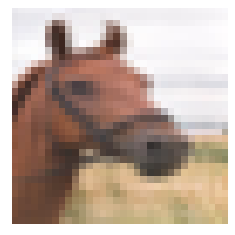

In [7]:
image_id = 99 # Index des Bildes aus Testset das geladen werden soll
helper.plot_image(x_test[image_id])

## Pixelmanipulation

Als allererstes brauchen wir eine Funktion die in der Lage ist Pixel in einem Bild zu verändern.

Hierzu wird jedes Pixel als 5-tupel definiert.

$$\textbf{x} = (x, y, r, g, b)$$

Dabei sind $x$ und $y$ die Kooridinaten des Pixels im Bild (jeweils von 0 bis 31). $r,g,b$ geben die Farbwerte des Pixels an (jeweils von 0 bis 255).

Mehrere dieser Veränderungen, auch Pertubations genannt, werden wie folgt erzeugt:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

Grund dafür ist, dass der Optimierungsalgorithmus, der später vorgestellt wird einen eindimensionales Array als Eingabe erwartet.

Zumsammengefasst bedeutet das, das die Funktion ein Bild sowie den Pertubationvektor $X$ als Eingabe erhält und als Ausgabe ein Bild produziert welches die veränderten Pixel enthält.

Da es später notwendig ist, dass aus einem Bild viele Versionen mit unterschiedlichen Pixelmanipulationen erzeugt werden, werden mehrere Pertubations zu $X_S$ zusammengefasst.


In [8]:
def perturb_image(xs, img):
    # wenn nur ein Vektor gegeben wird,
    # wird dieser trotzdem in ein Array der Länge 1 gepackt,
    # damit die Berechnung gleich bleibt
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # das Bild wird nun so oft kopiert wie es Veränderungen gibt (n==len(xs))
    # um die selbe Anzahl an veränderten Bildern zu erhalten (n veränderte Bilder)
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Sichert zu das Inhalt von xs nur aus Integer Werten besteht
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # nun wird der Veränderungsvektor in seine einzelnen 5-Tupel Bestandteile zerlegt
        # z.b. [[x,y,r,g,b],[x2,y2,r2,g2,b2], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # nun wird dem Pixel sein neuer RGB Wert zugewiesen
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

Jetzt sind wir in der Lage jedes Pixel eines Bildes zu verändern wie wir wollen.

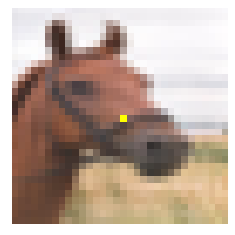

In [11]:
image_id = 99
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

## Laden von Vortrainierten KI Modellen

Um übehaupt einen Angriff auszuführen, brauchen wir erst ein KI Netzwerk.
Diese sind hier bereits auf das Cifar10 Datenset trainiert.

Hier sind 2 Netzwerke enthalten, LeNet und ResNet.

In [12]:
lenet = LeNet()
resnet = ResNet()

models = [lenet, resnet]

Successfully loaded lenet
Successfully loaded resnet


## Vorhersage Funktion

##vereinfachen

Da wir in der Lage sein wollen die selbe Methode auf unterschiedliche Image Classfier anzuwenden, sind für uns nur die Inputs und Outputs der Netzwerke von Bedeutung. Das heißt wir behandeln die KI als "Black-Box" Algorithmus.

Bei den Outputs sind hier vorallem die Prediction Probabilities wichtig. Diese geben an wie Wahrscheinlich unterschiedliche Klassen, nach wissen des Netzwerkes, sind.

Diese Funktion verwendet nun die ``predict`` Funktion eines Keras KI-Modells.
In dieser werden nun die Prediction Probalility einer Zielklasse `target_class` des Bildes ermittelt. Dieser wird auch als Confidence einer bestimmten Zielklasse bezeichnet.

Ziel wird es später die Confidence der tatsächlich korrekten Klasse zu senken oder, je nach Art des Angriffs, die Confidence einer bestimmten Zielklasse zu steigern.

Da wir den selben Optimierungsalgorithmus für beide Fälle verwenden wird hier eine Unterscheidung durchgeführt. Der Optimierungsalgorithmus, der die optimale Position und Farbe eines Pixels ermittelt, ist nämlich nur in der Lage ein Minimum zu finden. Dadurch wird im zweiten Fall `1-predictions` zurückgegeben.

In [10]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Verändern des Bildes mithilfe des Veränderungsvektor xs
    imgs_perturbed = perturb_image(xs, img)
    # Confidence des Netzwerkes ermittelt, mit welcher das veränderte Bild teil der Zielklasse ist
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # Diese Funktion wird immer minimiert, deshalb wird hier zwischen zwei Fällen unterschieden
    return predictions if minimize else 1 - predictions

Unten wird dieses Verhalten expemplarisch demonstiert.

Dies ist ein Beispiel, indem sowohl die Position als auch die Farbe des Pixels bereits optimiert wurde.

1/1 [==============================] - 0s 26ms/step
Confidence der korrekten Klasse bird ist 0.00018887446 %
Vorherige confidence war 0.70661753 %


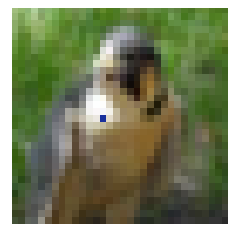

In [15]:
image_id = 384
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

print('Confidence der korrekten Klasse', class_names[true_class], 'ist', confidence,'%')
print('Vorherige confidence war', prior_confidence, '%')
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

# Teil 2

## Der Angriff

Nun können wir den eigentlichen Angriff aufbauen.

### Targeted vs. Untargeted Attacks

## Raus

Es wird hier zwischen zwei Angriffsarten unterschieden:
1. Untargeted Attack
2. Targetet Attack

Bei Untargetet Attacks (ungezielter Angriff) ist das Ziel ein Bild falsch zu klassifieren. Das heißt wir wollen durch die Veränderung eines oder mehrerer Pixel das Netzwerk dazu bringen, das es das original Bild nicht mehr der richtigen Kategorie zuordnet.
Dazu soll die Confidence der korrekten Klasse so weit gesenkt werden das eine beliebige andere Klasse nun als wahrscheinlichste Klasse erkannt wird.
Welche Klasse dies ist spielt dabei allerdings keine Rolle.

Bei Targetet Attacks (gezielter Angriff) verfolgen wir das Ziel, nicht nur das Bild falsch zu klassifieren, sondern das es eine bestimme Klasse erkennt.
Der Unterschied zu untargetet Attacks besteht darin, das wir nicht versuchen die Confidence der korrekten Klasse zu schwächen, sondern die Confidence einer bestimmten anderen Klasse zu stärken.

Diese Unterscheidung ist der Grund wieso wir bei ``predict_class()`` Funktion zwei Fälle unterschieden haben.

### Erfolgskriterium

## aus angriffs sektion raus?

Nun muss eine Funktion definiert werden, welche angibt ob ein Angriff ein Erfolg war.
Die Funktion gibt ``True`` zurück wenn der Angriff erfolgreich war.

Da dies abhängig von der Art des Angriffs ist, wird ein ``targeted_attack`` flag verwendet um die zwei Angriffstypen zu unterscheiden.

In [ ]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    # Verändern des Bildes durch Manipulation von Pixeln
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # gibt nur an wie die Ausgabe erfolgen soll
    if verbose:
        print('Confidence:', confidence[target_class])
    # Wenn die Prediction erreicht hat was unser Ziel ist
    # (Targeted oder Untargeted Attack) True zurückgeben
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # ist der Angriff kein Erfolg wird None zurückgegeben, dies wird für die Optimierung wichtig (eigenheit von SciPy)

## mir codeblock raus?

Unten wird gezeigt wie die Funktion funktioniert.

Die Ausgabe ist sehr ähnlich zu ``predict_class()``, allerdings wird ermittelt ob der Angriff erfolgreich war.

1/1 [==============================] - 0s 31ms/step
Confidence: 0.07460071
Prior confidence 0.50054216
Attack success: True


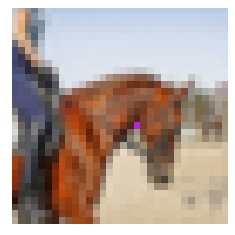

In [ ]:
image_id = 541
pixel = np.array([17, 18, 185, 36, 215])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

### Angriffs Funktion

## RAUS

Nun fehlt nurnoch die eigentliche Angriffsfunktion die die optimale Position und Farbe des Pixels ermittelt, welches, je nach gewählter Angriffsstrategie, das beste Ergebnis erzielt.

Zu erst muss das Optimierungsproblem klar erkenntlich sein. 
Dies ist hier unsere ``predict_classes`` Funktion, welche ein manipuliertes Bild mit einem entsprechenden Confidence Wert des Image Detection Netzwerks verknüpft.

Da es sich hierbei um einen blakc-box Angriff handelt, sind Optimierungsmodelle die auf gradient-descend basieren schwierig umzusetzen, da diese sich darauf verlassen das die "Kurve" der zu optmierenden Funktion glatt ist.
Da hier aber mit Integerwerten sowohl für die X und Y Positionen des Pixels als auch für desen R, G, B Werte verwendet werden, können wir davon ausgehen das die Optimierungskurve nicht glatt sondern sehr ungleichmäßig sein wird.

Man kann sich aber die Funktionsweise wiefolgt vorstellen:

Zuerst werden verschiedene Werte für die Parameter (X,Y,R,G,B) getestet und die resultiertende Confidence des Netzwerkes wird ermittelt.

Stellt man sich nun jeden Parameter als Dimension im Raum vor so erhält man dann einen Graphen, welche das Optimierungsproblem darstellt.

Die Aufgabe des Optimierungsalgorithmus besteht nun darin, in möglichst wenigen Schritten das globale Minimum des Graphen (entlang der Confidence-Achse) zu finden.
Das heißt er sucht die perfekten Werte für alle Parameter, bis zu dem Grad an dem wir definiert haben wann er aufhören kann, nämlich wenn der Angriff erfolgreich war.

Für dies bei einer unebenen Funktion zu erreichen verwenden wir hier den so genannten [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution) Algorithmus.

Das Bild zeigt die Anwendung dieses Algorithmus, zur besseren Vorstellung, für die Optimierung der sogenannten [Ackley function](https://en.wikipedia.org/wiki/Ackley_function). 
Dabei handelt es sich um ein Optimierungsproblem aus der Mathematik mit nur zwei Inputparametern, weshalb der Graph noch darstellbar ist.


<br>

![Ackley GIF](https://github.com/hyperparticle/one-pixel-attack-keras/blob/master/images/Ackley.gif?raw=1)

<br>


Der Differential Evolution Algorithmus ist ein auf Evolution basierender Algorithmus. Hierbei werden Vektoren, welche die einzelnen Parameter enhalten als Input benutzt. 

Grober Ablauf:

1. Zu Beginn werden zufällig eine vordefinierte Menge solcher Vektoren erzeugt
2. Zu jedem dieser Vektoren wird dann die Confidence das Image-Detection Modells errechnet.
3. Durch Zusammenfügen (Mutation) mehrerer dieser Vektoren werden dann neue Vektoren erzeugt
4. schneiden die neuen Vektoren besser ab als Teile der Eltern-Vektoren so ersetzen sie diese
5. ab Schritt 2 wiederholen bis das ``attack_success`` Kriterium erfüllt ist

Im Fall des One-Pixel Attacks ist der Input ein eindimensionaler Vektor der veränderten Pixel

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

Dann muss die erste Generation an zufällig gewählten Pixeln erzeugt werden

$$\textbf{P} = (X_1, X_2, \dots, X_n)$$

Die mutierten Kinder dieser Generation werden erzeugt durch

$$X_i = X_{r1} + F (X_{r2} - X_{r3})$$

Wobei $r1 \neq r2 \neq r3$ erfüllt sein muss. $r1,r2,r3$ stellen dabei zufällig gewählte Indizes der Population $\textbf{P}$ dar. $F = 0.5$ ist der Mutationsparameter, der angibt wie genau der neue Vektor zusammengesetzt ist.

Hier wird eine [leicht angepasst Version](differential_evolution.py) des [Scipy Differential Evolution](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html) Algorithmus verwendet um die GPU-Beschleunigung besser nutzbar zu machen.


In [ ]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Zielklasse muss angepasst werden, je nachdem ob targeted oder untargeted attack
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    
    # der Algorithmus benötigt die Grenzwerte aller Parameter (x,y,r,g,b)
    # sollen mehrere Pixel verändert werden wird die bounds liste so oft wiederholt
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # zuvor erstellte predict_classes als zu optimierende Funktion und attack_succes als Callback umschreiben
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Aufruf des Differential Evolution Algorithmus
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Nützliche Kennzahlen berechnen
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Ergebnisbild nach der Suche ausgeben
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

#### Untargeted Attack

## RAUS

Nun können wir ein Bild aus unserem Cifar10-Datensatz angreifen!
Hier wird ein Bild mit dem untargeted Attack erfolgreich angegriffen.

Probiert gerne aus ob ihr andere Bilder erfolgreich manipulieren könnt.
Ein erneutes Ausführen der Zelle kann dabei bereits das Ergebnis beeinflussen durch das zufällige Erzeugen erste Population.
Man kann ebenso sehen das durch verwenden mehrerer Pixel die Erfolgschance steigt.

Man sieht wie die Confidence langsam sinkt, bis zu dem Punkt andem die Klasse falsch klassifiert wird.

1/1 [==============================] - 0s 33ms/step
Confidence: 0.7988974
1/1 [==============================] - 0s 27ms/step
Confidence: 0.7988974
1/1 [==============================] - 0s 25ms/step
Confidence: 0.7988974
1/1 [==============================] - 0s 33ms/step
Confidence: 0.7988974
1/1 [==============================] - 0s 31ms/step
Confidence: 0.59834874
1/1 [==============================] - 0s 38ms/step
Confidence: 0.59834874
1/1 [==============================] - 0s 30ms/step
Confidence: 0.5138304
1/1 [==============================] - 0s 26ms/step
Confidence: 0.5138304
1/1 [==============================] - 0s 30ms/step
Confidence: 0.5138304
1/1 [==============================] - 0s 25ms/step
Confidence: 0.5138304
1/1 [==============================] - 0s 31ms/step
Confidence: 0.41657776
1/1 [==============================] - 0s 31ms/step


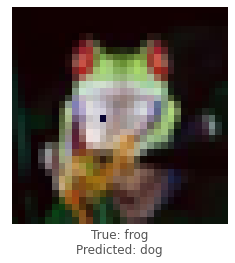

In [ ]:
image_id = 102
pixels = 1 # Anzahl der Pixel die maximal verändert werden dürfen
model = resnet

_ = attack(image_id, model, pixel_count=pixels, verbose=True)

#### Targeted Attack

## RAUS

Bei targeted attacks können wir wählen welche Klasse das Modell zu einem Bild erkennen soll. Diese Aufgabe ist bedeutend schwerer, also sinkt entsprechend die Trefferwahrscheinlichkeit.
Hier wird nun versucht die Confidence der Zielklasse über 50% zu heben, da sie durch das überschreiten dieser Schwelle zur wahrscheinlichsten Klasse wird. Dies lässt sich unten beobbachten.

Unten wird mit dem ``lenet`` Modell ein Bild von einem ``ship`` als ein ``automobile`` zu klassifizieren.
Probiere die Parameter zu ändern um andere Beipiele zu finden und die Funktionsweise besser zu verstehen.


Attacking with target automobile
1/1 [==============================] - 0s 28ms/step
Confidence: 0.020167617
1/1 [==============================] - 0s 20ms/step
Confidence: 0.020167617
1/1 [==============================] - 0s 18ms/step
Confidence: 0.024167025
1/1 [==============================] - 0s 21ms/step
Confidence: 0.024167025
1/1 [==============================] - 0s 18ms/step
Confidence: 0.07484922
1/1 [==============================] - 0s 20ms/step
Confidence: 0.07484922
1/1 [==============================] - 0s 17ms/step
Confidence: 0.07484922
1/1 [==============================] - 0s 17ms/step
Confidence: 0.07484922
1/1 [==============================] - 0s 17ms/step
Confidence: 0.12871696
1/1 [==============================] - 0s 17ms/step
Confidence: 0.12871696
1/1 [==============================] - 0s 17ms/step
Confidence: 0.12871696
1/1 [==============================] - 0s 20ms/step
Confidence: 0.12871696
1/1 [==============================] - 0s 23ms/step
Confidence:

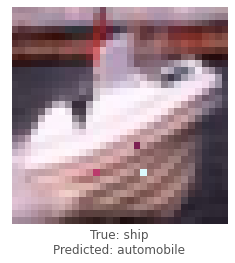

In [ ]:
image_id = 108
target_class = 1 # Integer Wert zwischen 0-9
pixels = 3
model = lenet

print('Attacking with target', class_names[target_class])
_ = attack(image_id, model, target_class, pixel_count=pixels, verbose=True)

## Conclusions

## RAUS

Es ist nicht sonderlich schwierig einen solchen Angriff aufzubauen, wie oben zu sehen ist. Um nun allerdings das gesammte Cifar10 Datenset anzugreifen um zu ermitteln wie robust die enthaltenen Bilder sind, sind große Mengen an Rechenresourcen und Zeit nötig. Deshalb wird dieser "letzte" Schritt in dieser Übung nicht näher betrachtet.

Würde man ihn durchführen würde sichtbar, das die Genauigkeit des Netzwerks keine starke Korellation zu der Erfolgrate des Angriffs besitzt.


## Quellen
- Diese Implementierung ist eine übersetze und stark angepasste Version der Implementierung von Dan Kondratyuk https://github.com/Hyperparticle/one-pixel-attack-keras
- Due Implementierung basiert auf dem Paper welches One-Pixel Attacks beschreibt: https://arxiv.org/abs/1710.08864
- Keras Cifar10 models: https://github.com/BIGBALLON/cifar-10-cnn
- Scipy's differential evolution Implementierung: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html?highlight=differential%20evolution